<a href="https://colab.research.google.com/github/ayyucedemirbas/depth-aware_object_detection/blob/main/depth_aware_object_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install supervision ultralytics

In [2]:
import cv2
import supervision as sv
import torch
import numpy as np
from ultralytics import YOLO

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
detection_model = YOLO('yolov8n.pt')
midas_model = torch.hub.load('intel-isl/MiDaS', 'MiDaS_small').to(device)
midas_model.eval()
midas_transforms = torch.hub.load('intel-isl/MiDaS', 'transforms')
transform = midas_transforms.small_transform

100%|██████████| 6.25M/6.25M [00:00<00:00, 141MB/s]
Downloading: "https://github.com/intel-isl/MiDaS/zipball/master" to /root/.cache/torch/hub/master.zip


Loading weights:  None


Downloading: "https://github.com/rwightman/gen-efficientnet-pytorch/zipball/master" to /root/.cache/torch/hub/master.zip
Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/tf_efficientnet_lite3-b733e338.pth" to /root/.cache/torch/hub/checkpoints/tf_efficientnet_lite3-b733e338.pth
Downloading: "https://github.com/isl-org/MiDaS/releases/download/v2_1/midas_v21_small_256.pt" to /root/.cache/torch/hub/checkpoints/midas_v21_small_256.pt
100%|██████████| 81.8M/81.8M [00:00<00:00, 88.4MB/s]
Using cache found in /root/.cache/torch/hub/intel-isl_MiDaS_master


In [5]:
image = cv2.imread('image.jpeg')
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

In [6]:
detection_result = detection_model(image)[0]
detections = sv.Detections.from_ultralytics(detection_result)


0: 448x640 3 birds, 38.2ms
Speed: 9.0ms preprocess, 38.2ms inference, 799.2ms postprocess per image at shape (1, 3, 448, 640)


In [7]:
input_tensor = transform(image_rgb).to(device)

with torch.no_grad():
    depth_prediction = midas_model(input_tensor)

In [8]:
depth_map = torch.nn.functional.interpolate(
    depth_prediction.unsqueeze(1),
    size=image.shape[:2],
    mode='bicubic',
    align_corners=False
).squeeze().cpu().numpy()

In [9]:
depth_min, depth_max = depth_map.min(), depth_map.max()
depth_map_normalized = (depth_map - depth_min) / (depth_max - depth_min + 1e-6) * 10

In [10]:
depth_estimates = []
for bbox in detections.xyxy:
    x1, y1, x2, y2 = bbox.astype(int)
    x1, y1 = max(0, x1), max(0, y1)
    x2, y2 = min(image.shape[1], x2), min(image.shape[0], y2)

    if x1 >= x2 or y1 >= y2:
        depth_estimates.append(0.0)
        continue

    depth_roi = depth_map_normalized[y1:y2, x1:x2]
    depth_estimates.append(np.mean(depth_roi))

In [11]:
labels = [
    f"{detection_model.model.names[class_id]} {depth:.2f}m"
    for class_id, depth in zip(detections.class_id, depth_estimates)
]

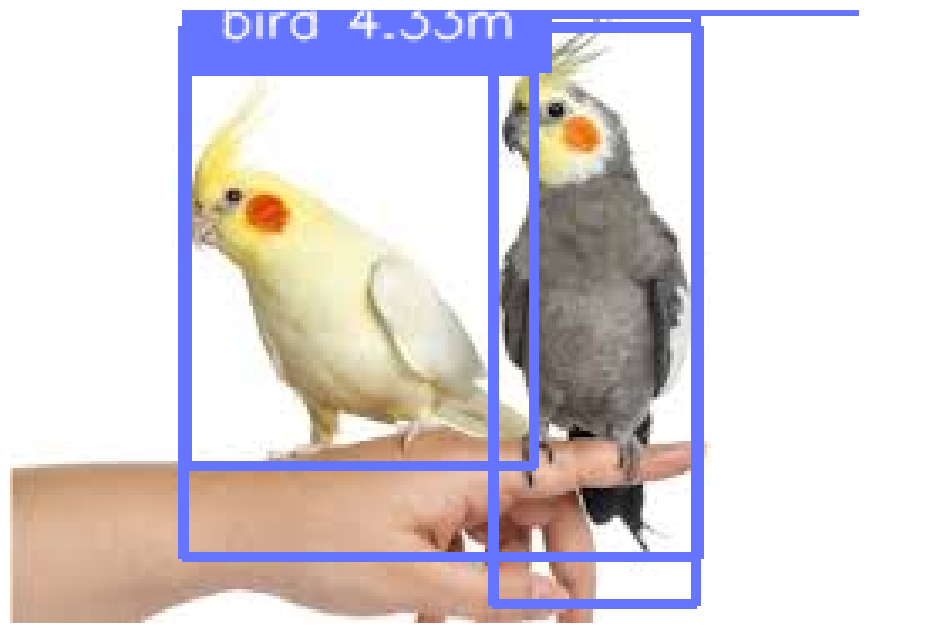

In [16]:
box_annotator = sv.BoxAnnotator()
label_annotator = sv.LabelAnnotator()


annotated_image = box_annotator.annotate(
    scene=image.copy(),
    detections=detections
)

# Then annotate labels with depth information
annotated_image = label_annotator.annotate(
    scene=annotated_image,
    detections=detections,
    labels=labels
)


sv.plot_image(annotated_image)